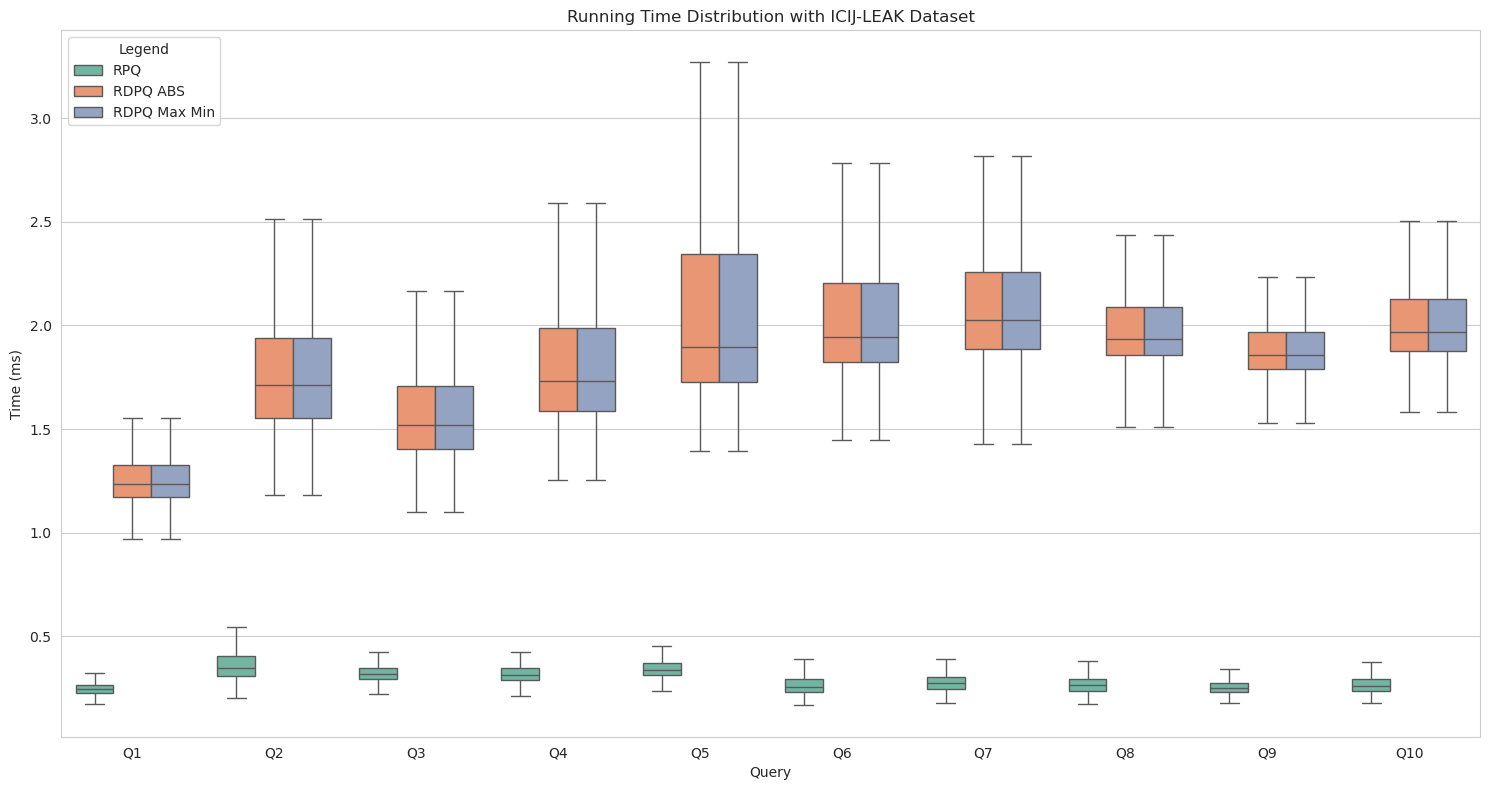

In [1]:
import pickle 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
with open("result/icij_static.pkl","rb+") as f:
    data_ytb = pickle.loads(f.read()) 

data_groups = []
for i in range(10):  # Q1-Q10
    id = 0
    for dtype in ["RPQ", "RDPQ ABS", "RDPQ Max Min"]:  # 3 种数据类型
        data = list(map(lambda x: x, data_ytb[i*3 + id][2])) # 乘1000转换为ms
        id = id + 1
        data_groups.append((f"Q{i+1}", dtype, data))
# 转换为 DataFrame
df_list = []
for group, dtype, values in data_groups:
    for v in values:
        df_list.append((group, dtype, v))
df = pd.DataFrame(df_list, columns=["Query", "Data Constraint", "Running Time"])

# 计算每组数据的平均值
mean_values = df.groupby(["Query", "Data Constraint"])["Running Time"].mean().reset_index()

# 设置绘图风格
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# **改回线性坐标**
# plt.yscale("log")  # 移除对数坐标

# 绘制箱线图
ax = sns.boxplot(x="Query", y="Running Time", hue="Data Constraint", data=df, palette="Set2", showfliers=False)


# **调整 Y 轴单位（毫秒）**
plt.ylabel("Time (ms)")

# 调整图例
plt.legend(title="Legend", loc="upper left")

# 添加标题
plt.title("Running Time Distribution with ICIJ-LEAK Dataset")

# 旋转 X 轴标签
# plt.xticks(rotation=45)

# **自动调整布局，防止标签重叠**
plt.tight_layout()

# 显示图表
plt.show()

In [9]:
import pickle 
import numpy as np
import functools
with open("icij-leak/icij_leak_statistic.pkl","rb+") as f:
    data_ytb = pickle.loads(f.read()) 
with open("icij-leak-naive/icij_leak_naive_statistic.pkl","rb+") as f1:
    data_ytb1 = pickle.loads(f1.read()) 

for i in range(len(data_ytb)):
    print(f"{data_ytb[i][1]} query, the max time difference is {format(np.max(data_ytb[i][2])-np.max(data_ytb1[i][2]),'.3f')} ms, the average time difference  is {format(np.mean(data_ytb[i][2]-np.mean(data_ytb1[i][2])),'.3f')} ms")

REGEX Q0 query, the max time difference is 0.109 ms, the average time difference  is 0.002 ms
RDPQ Q11 query, the max time difference is -0.127 ms, the average time difference  is -0.014 ms
RDPQ Q12 query, the max time difference is 0.064 ms, the average time difference  is -0.009 ms
RDPQ Q13 query, the max time difference is -0.072 ms, the average time difference  is -0.018 ms
RDPQ Q14 query, the max time difference is 0.182 ms, the average time difference  is 0.043 ms
RDPQ Q15 query, the max time difference is 2.612 ms, the average time difference  is 5.406 ms
REGEX Q1 query, the max time difference is 0.716 ms, the average time difference  is 0.247 ms
RDPQ Q21 query, the max time difference is 4.779 ms, the average time difference  is 4.113 ms
RDPQ Q22 query, the max time difference is 3.906 ms, the average time difference  is 3.548 ms
RDPQ Q23 query, the max time difference is 3.454 ms, the average time difference  is 3.507 ms
RDPQ Q24 query, the max time difference is 2.660 ms, th

In [30]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_max_comparison(path, path2, name1, name2, log_scale=True):
    # Load both datasets
    with open(path, "rb+") as f:
        data1 = pickle.loads(f.read())
    with open(path2, "rb+") as f:
        data2 = pickle.loads(f.read())
    
    # Process both datasets
    data_groups = []
    for dataset, name in [(data1, name1), (data2, name2)]:
        for i in range(12):  # Q1-Q10
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:
                    id += 1
                    continue
                data = list(map(lambda x: x, dataset[i*6 + id][2]))
                id += 1
                data_groups.append((f"Q{i+1}", dtype, name, data))

    # Prepare max values for plotting
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        plot_data.append({
            'Query': group,
            'Data Constraint': dtype,
            'Dataset': dataset_name,
            'Max': np.max(values)
        })
    df = pd.DataFrame(plot_data)
    
    # Create subplots
    num_queries = 12
    cols = 6
    rows = (num_queries + cols - 1) // cols
    plt.figure(figsize=(20, 6*rows))
    sns.set_style("whitegrid")

    for idx, query in enumerate(range(1, num_queries + 1), 1):
        ax = plt.subplot(rows, cols, idx)
        query_df = df[df['Query'] == f"Q{query}"]
        if query_df.empty:
            raise ValueError(f"No data available for Q{query}")
        # Plot max values as lines
        sns.lineplot(data=query_df, x='Data Constraint', y='Max', 
                    hue='Dataset', style='Dataset',
                    markers=True, dashes=False, ax=ax,
                    markersize=8, linewidth=2.5)
        ax.get_legend().remove() 
        
        ax.set_title(f"Max: {query}")
        ax.set_xlabel("Data Constraint")
        ax.set_ylabel("Time (ms)")
        plt.xticks(rotation=45)
        
        # Check for log scale
        max_val = query_df['Max'].max()
        min_val = query_df['Max'].min()
        if log_scale and max_val / min_val > 100:
            ax.set_yscale("log")
            ax.set_title(f"Max: {query} (log scale)")
    
    plt.suptitle(f"Maximum Running Time Comparison: {name1} vs {name2}", y=1.02)
    handles, labels = ax.get_legend_handles_labels()

    # Create single legend above all subplots
    plt.figlegend(handles, labels, loc='upper left', 
                bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'figure/{name1}-vs-{name2}-max-comparison.svg', 
                format='svg', dpi=1200, bbox_inches='tight')
    plt.show()
def plot_mean_comparison(path, path2, name1, name2, log_scale=True):
    # Load both datasets
    with open(path, "rb+") as f:
        data1 = pickle.loads(f.read())
    with open(path2, "rb+") as f:
        data2 = pickle.loads(f.read())
    
    # Process both datasets
    data_groups = []
    for dataset, name in [(data1, name1), (data2, name2)]:
        for i in range(12):  # Q1-Q10
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:
                    id += 1
                    continue
                data = list(map(lambda x: x, dataset[i*6 + id][2]))
                id += 1
                data_groups.append((f"Q{i+1}", dtype, name, data))

    # Prepare mean values for plotting
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        plot_data.append({
            'Query': group,
            'Data Constraint': dtype,
            'Dataset': dataset_name,
            'Mean': np.mean(values)
        })
    df = pd.DataFrame(plot_data)
    
    # Create subplots
    num_queries = 12
    cols = 6
    rows = (num_queries + cols - 1) // cols
    plt.figure(figsize=(20, 6*rows))
    sns.set_style("whitegrid")

    for idx, query in enumerate(range(1, num_queries + 1), 1):
        ax = plt.subplot(rows, cols, idx)
        query_df = df[df['Query'] == f"Q{query}"]
        
        # Plot mean values as lines
        sns.lineplot(data=query_df, x='Data Constraint', y='Mean', 
                    hue='Dataset', style='Dataset',
                    markers=True, dashes=False, ax=ax,
                    markersize=8, linewidth=2.5)
        ax.get_legend().remove() 
        
        ax.set_title(f"Mean: {query}")
        ax.set_xlabel("Data Constraint")
        ax.set_ylabel("Time (ms)")
        plt.xticks(rotation=45)
        
        # Check for log scale
        max_val = query_df['Mean'].max()
        min_val = query_df['Mean'].min()
        if log_scale and max_val / min_val > 100:
            ax.set_yscale("log")
            ax.set_title(f"Mean: {query} (log scale)")
    
    plt.suptitle(f"Average Running Time Comparison: {name1} vs {name2}", y=1.02)
    handles, labels = ax.get_legend_handles_labels()

    # Create single legend above all subplots
    plt.figlegend(handles, labels, loc='upper left', 
                bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'figure/{name1}-vs-{name2}-mean-comparison.svg', 
                format='svg', dpi=1200, bbox_inches='tight')
    plt.show()

def plot_timeout_comparison(path, path2, name1, name2, timeout, log_scale=True):
    # Load both datasets
    with open(path, "rb+") as f:
        data1 = pickle.loads(f.read())
    with open(path2, "rb+") as f:
        data2 = pickle.loads(f.read())
    
    # Process both datasets
    data_groups = []
    for dataset, name in [(data1, name1), (data2, name2)]:
        for i in range(12):  # Q1-Q10
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:
                    id += 1
                    continue
                data = list(map(lambda x: x, dataset[i*6 + id][2]))
                id += 1
                data_groups.append((f"Q{i+1}", dtype, name, data))

    # Prepare mean values for plotting
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        plot_data.append({
            'Query': group,
            'Data Constraint': dtype,
            'Dataset': dataset_name,
            'TimeOut': len(list(filter(lambda x: (x/1000) > timeout, values)))
        })
    df = pd.DataFrame(plot_data)
    
    # Create subplots
    num_queries = 12
    cols = 6
    rows = (num_queries + cols - 1) // cols
    plt.figure(figsize=(20, 6*rows))
    sns.set_style("whitegrid")

    for idx, query in enumerate(range(1, num_queries + 1), 1):
        ax = plt.subplot(rows, cols, idx)
        query_df = df[df['Query'] == f"Q{query}"]

        # Plot mean values as lines
        sns.lineplot(data=query_df, x='Data Constraint', y='TimeOut', 
                    hue='Dataset', style='Dataset',
                    markers=True, dashes=False, ax=ax,
                    markersize=8, linewidth=2.5)
        ax.get_legend().remove() 
        ax.set_title(f"{query}/Timeout Threshold:{timeout}s")
        ax.set_xlabel("Data Constraint")
        ax.set_ylabel("Number of Time Out Queries")
        # ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.6f}%"))
        plt.xticks(rotation=45)
        
        # # Check for log scale
        # max_val = query_df['Timeout'].max()
        # min_val = query_df['Mean'].min()
        # if log_scale and max_val / min_val > 100:
        #     ax.set_yscale("log")
        #     ax.set_title(f"Mean: {query} (log scale)")
    
    plt.suptitle(f"Timeout Comparison: {name1} vs {name2}", y=1.02)
# Get handles/labels from last subplot (they're the same for all)
    handles, labels = ax.get_legend_handles_labels()

    # Create single legend above all subplots
    plt.figlegend(handles, labels, loc='upper left', 
                bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'figure/{name1}-vs-{name2}-timeout-comparison.svg', 
                format='svg', dpi=1200, bbox_inches='tight')
    plt.show()

def plot_compare(path1, path2, name, timeout, log=True):
    plot_max_comparison(path1, path2, f"{name}-Optimized", f"{name}-Naive", log)
    plot_mean_comparison(path1, path2, f"{name}-Optimized", f"{name}-Naive", log)
    plot_timeout_comparison(path1, path2, f"{name}-Optimized", f"{name}-Naive", timeout)



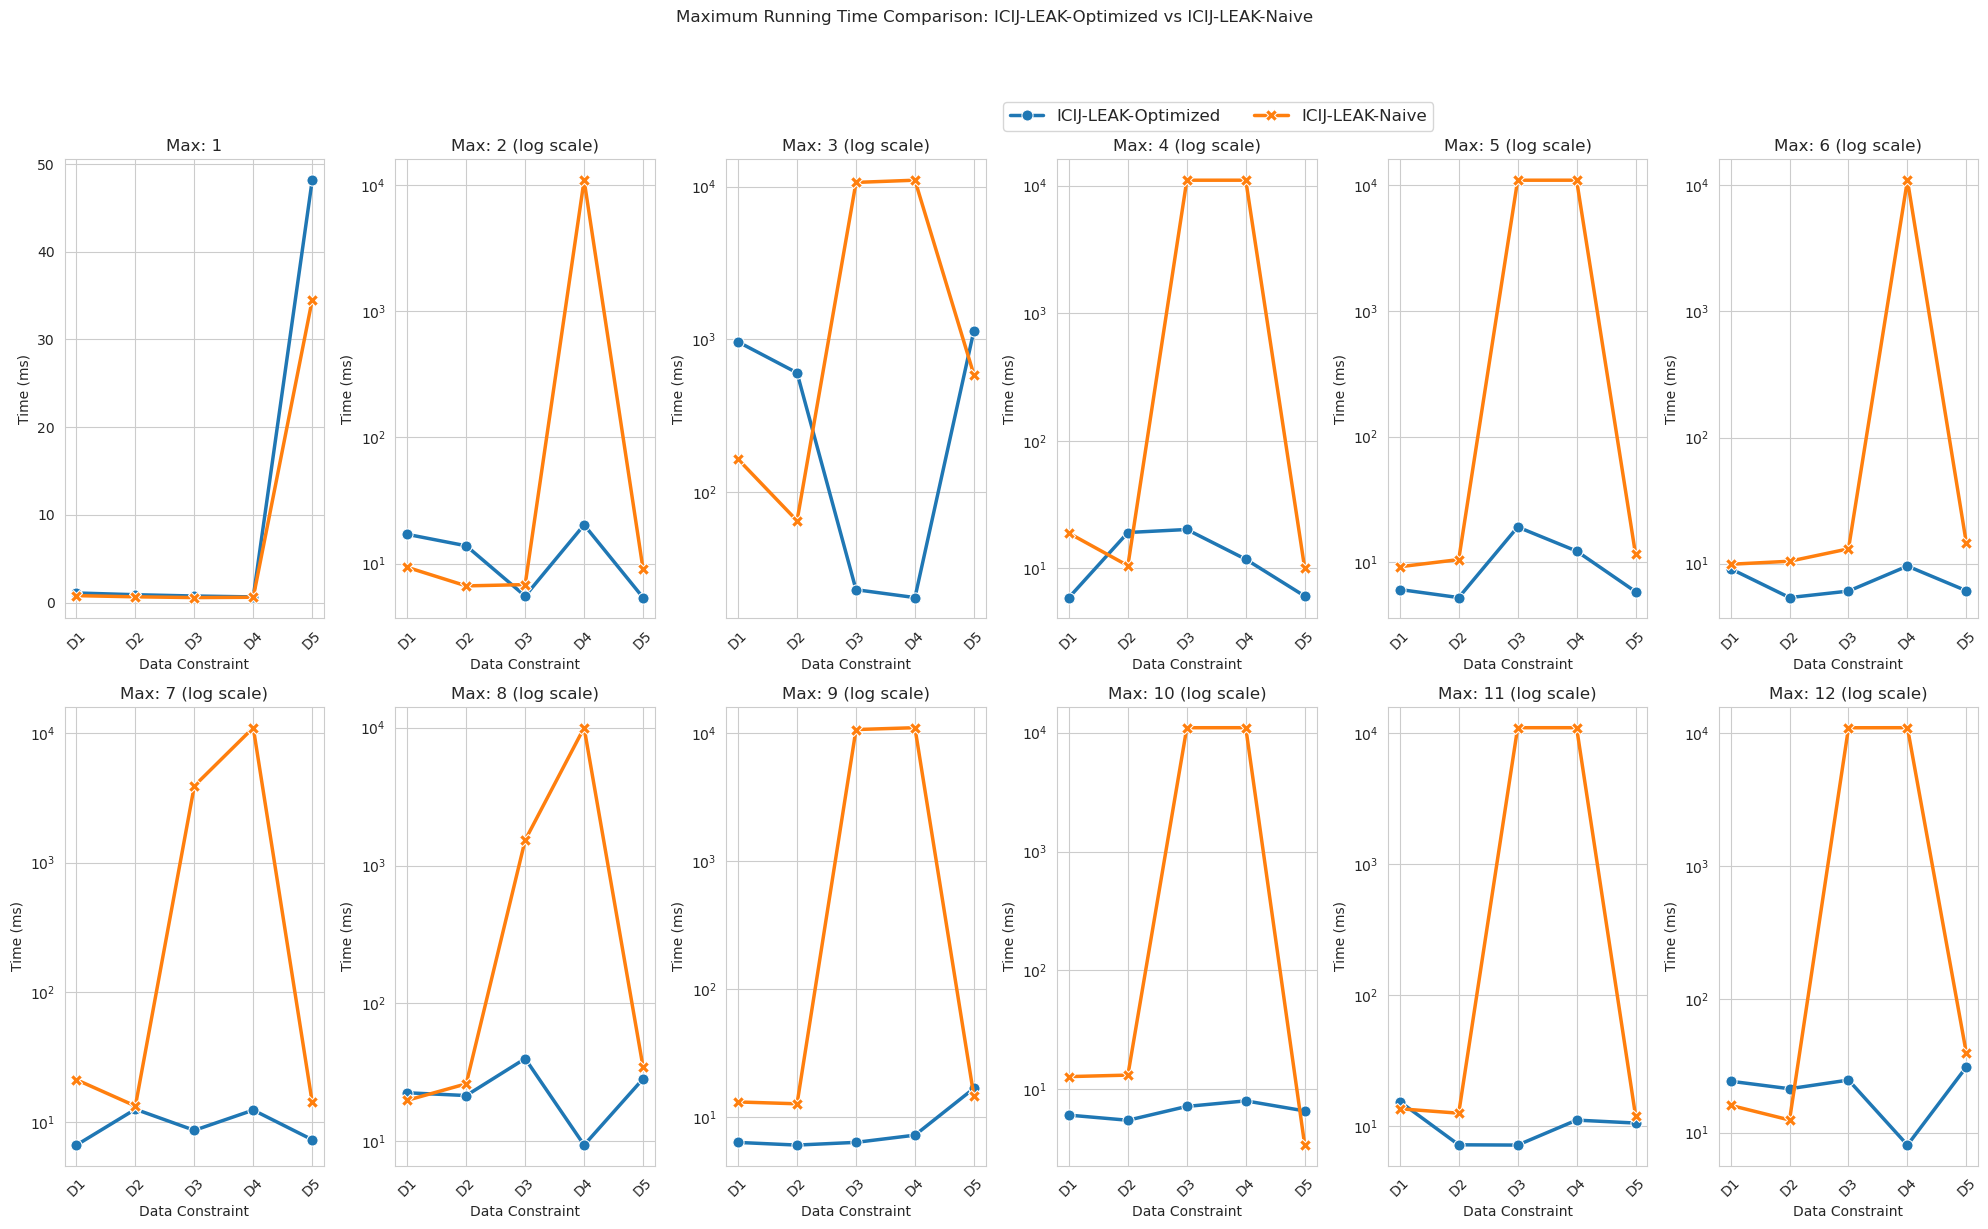

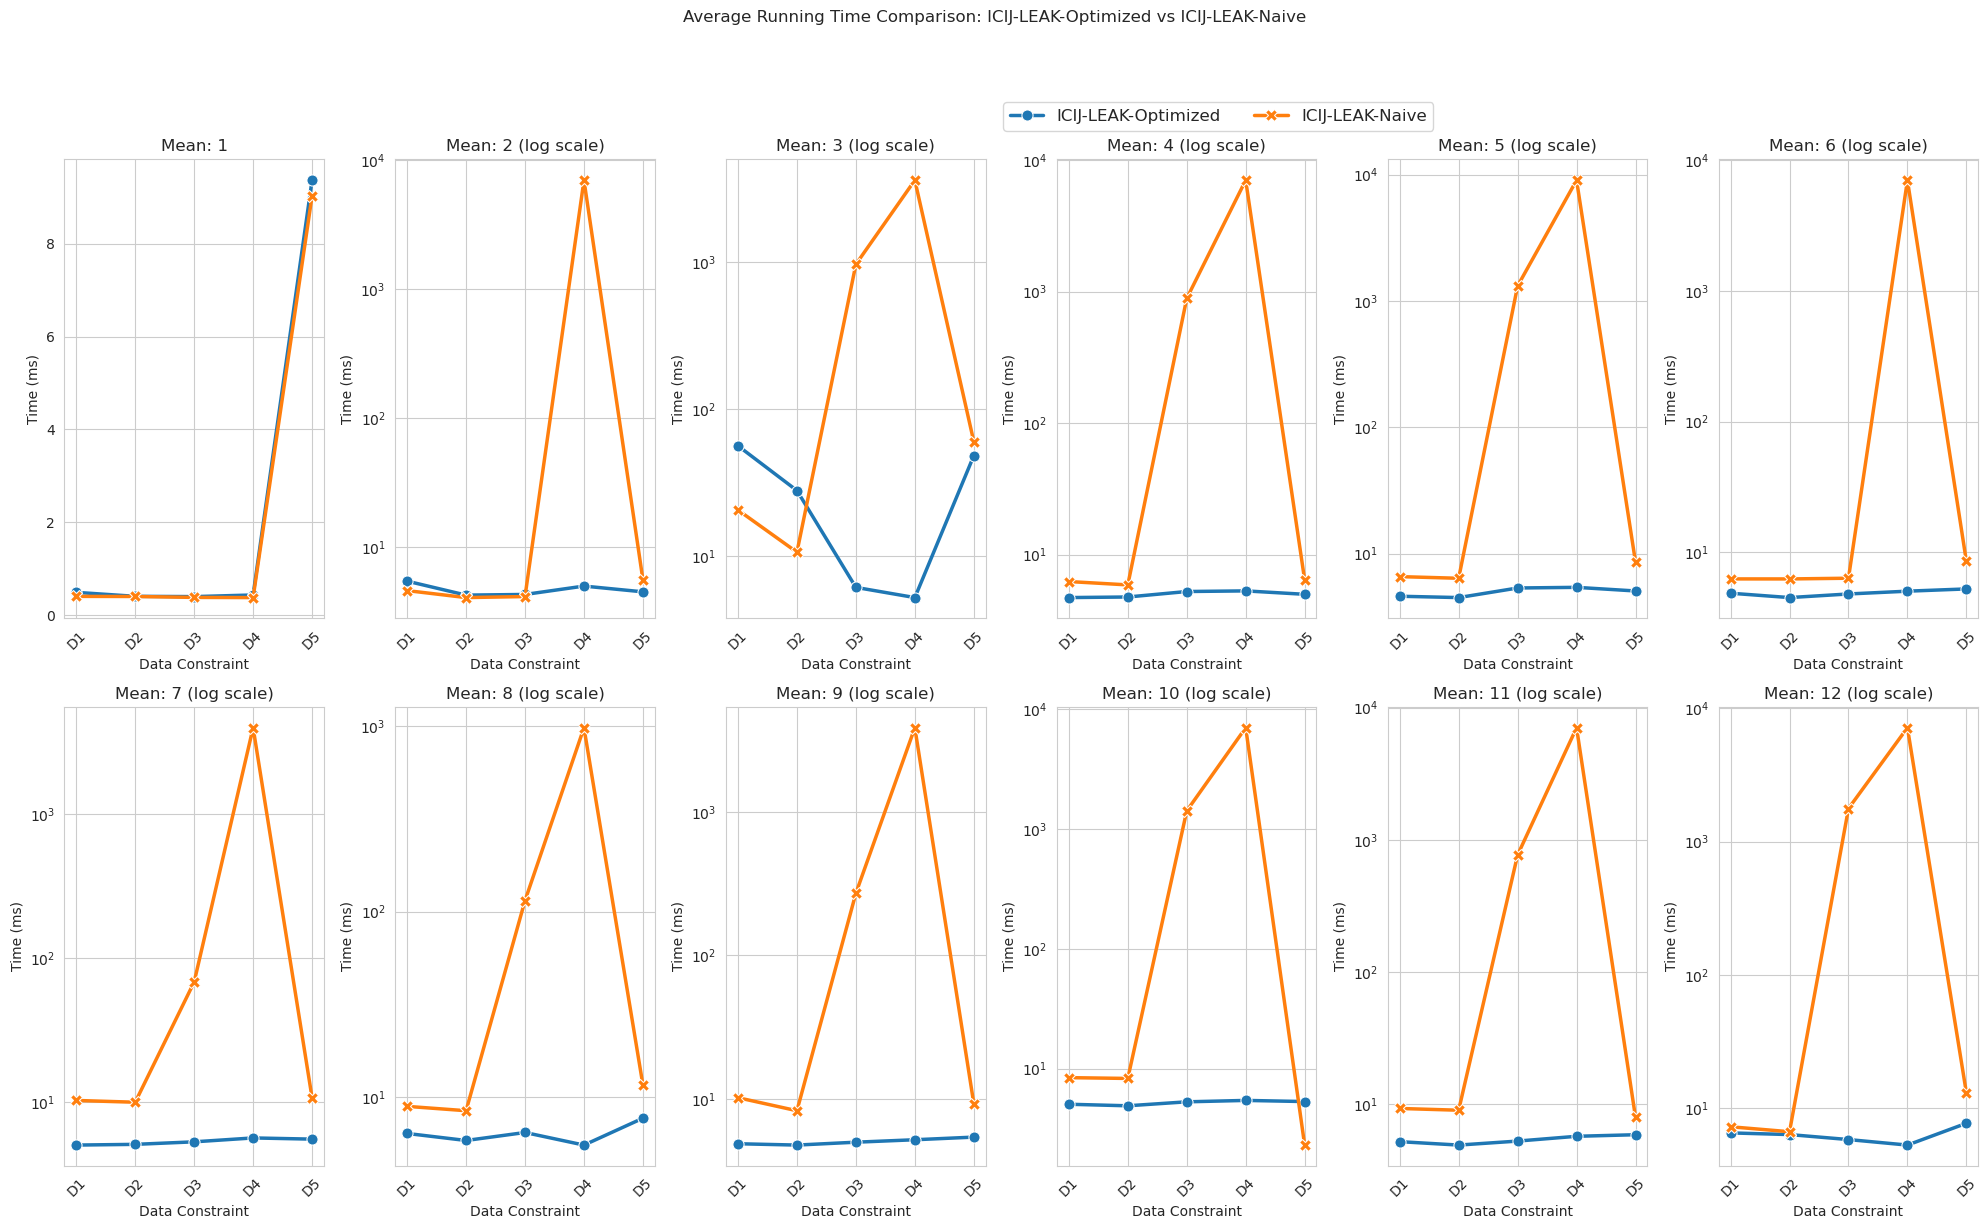

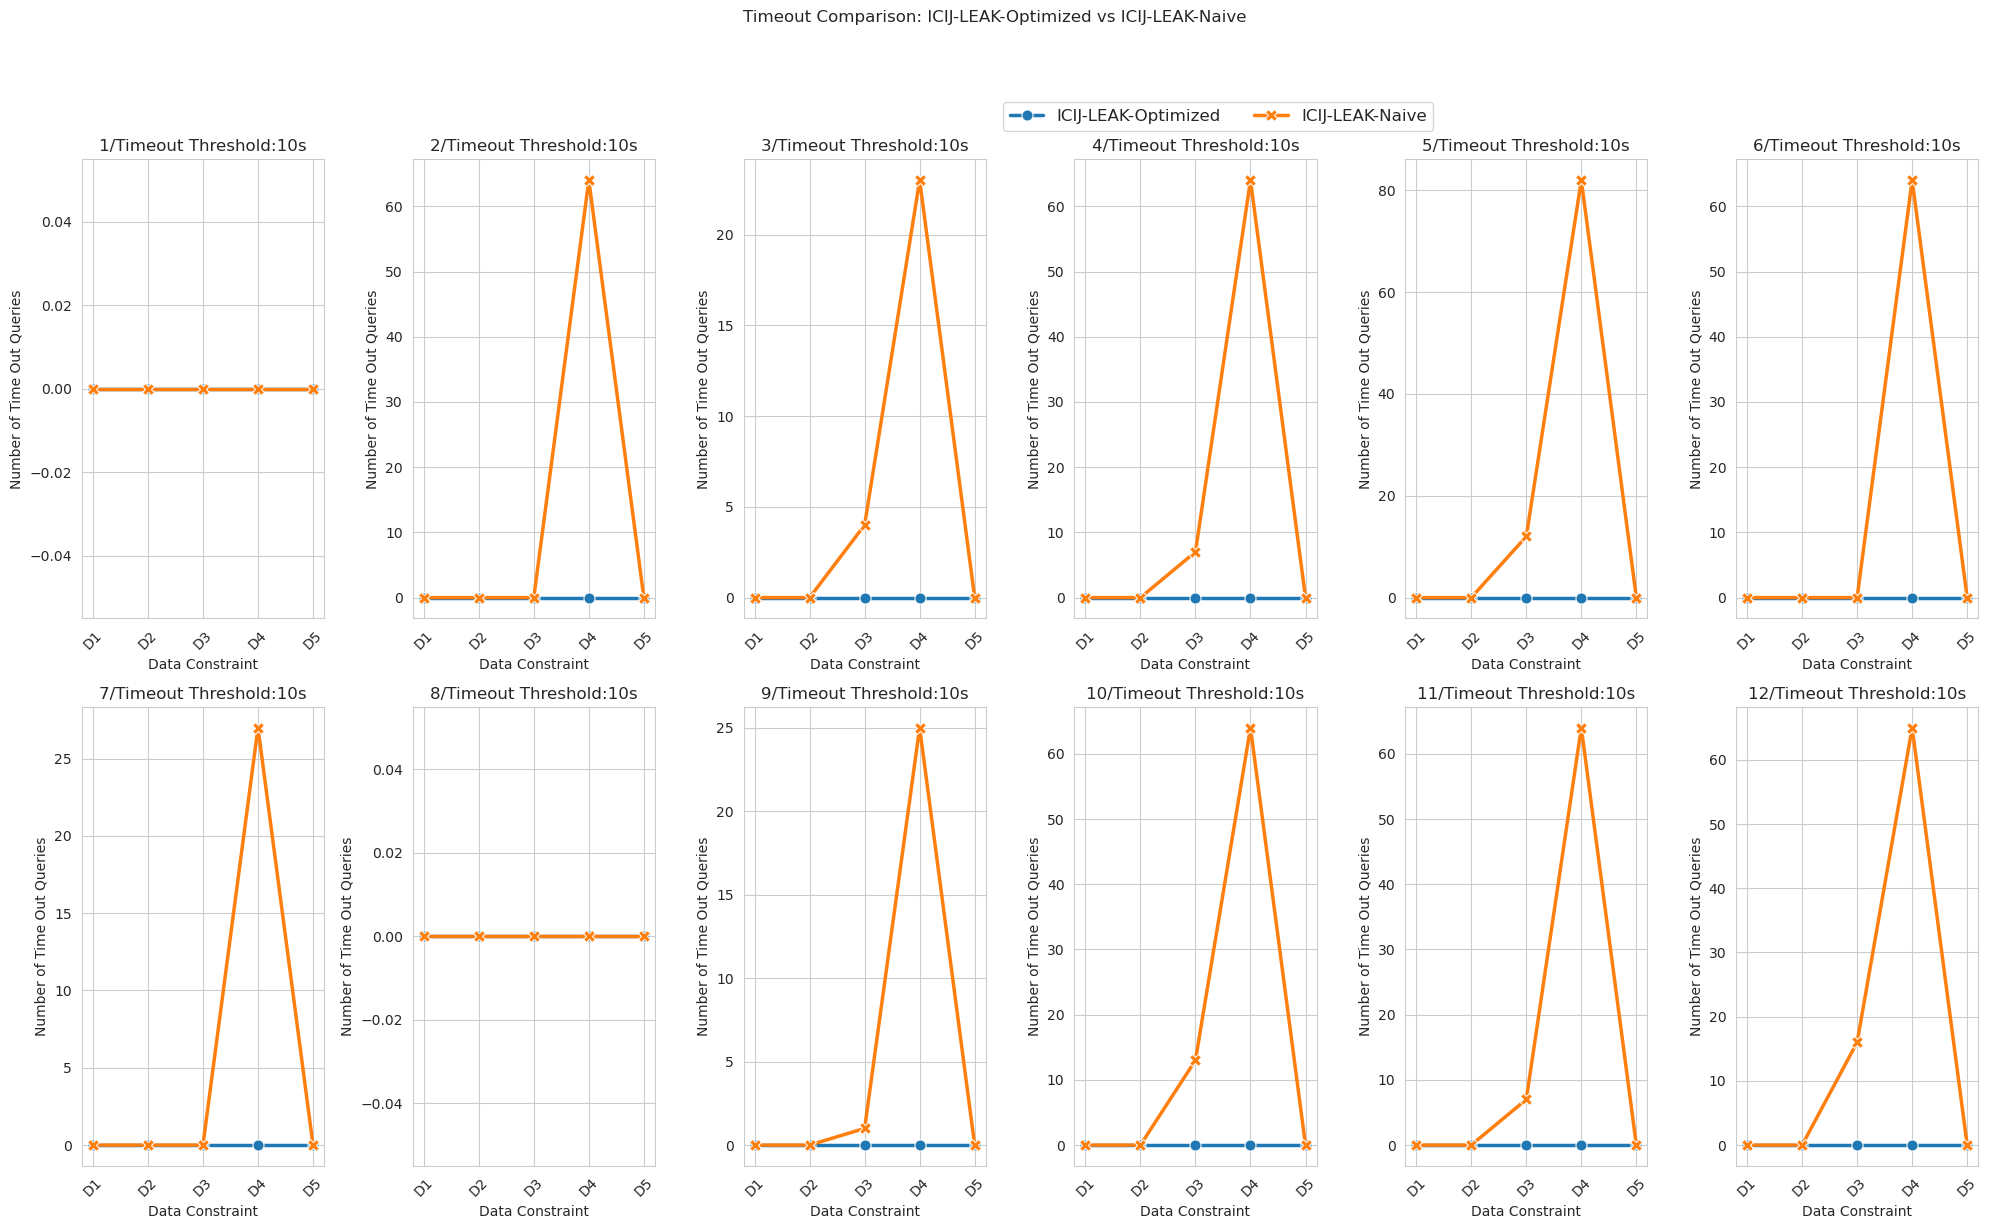

In [32]:
plot_compare("pokec/pokec_statistic.pkl", "pokec-naive/pokec_naive_statistic.pkl", "ICIJ-LEAK", 10, True)

In [7]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_boxplot_with_timeout(path, path2, ds, name1="Optimized", name2="Naive",timeout=10,  log_scale=True):
    # Load both datasets
    with open(path, "rb+") as f:
        data1 = pickle.loads(f.read())
    with open(path2, "rb+") as f:
        data2 = pickle.loads(f.read())
    
    # Process both datasets
    data_groups = []
    for dataset, name in [(data1, name1), (data2, name2)]:
        for i in range(12):  # Q1-Q12
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:
                    id += 1
                    continue
                data = list(map(lambda x: x, dataset[i*6 + id][2]))
                id += 1
                data_groups.append((f"Q{i+1}", dtype, name, data))

    # Prepare data for box plotting
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        for value in values:
            plot_data.append({
                'Query': group,
                'Data Constraint': dtype,
                'Dataset': dataset_name,
                'Time': value,
                'IsTimeout': (value / 1000) > timeout
            })
    
    df = pd.DataFrame(plot_data)
    
    # Create subplots
    num_queries = 12
    cols = 6
    rows = (num_queries + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(24, 8*rows))
    axes = axes.flatten()  # Flatten for easier indexing
    sns.set_style("whitegrid")

    # Calculate global min/max for consistent y-axis scaling (optional)
    global_min_time = df[df['Time'] > 0]['Time'].min()  # Exclude zeros for log scale
    global_max_time = df['Time'].max()

    for idx, query in enumerate(range(1, num_queries + 1), 1):
        ax = axes[idx-1]
        query_df = df[df['Query'] == f"Q{query}"]
        if query_df.empty:
            ax.set_title(f"No data for Q{query}")
            continue
        
        # Create box plots
        boxplot = sns.boxplot(data=query_df, x='Data Constraint', y='Time', 
                             hue='Dataset', ax=ax, showfliers=False,
                             palette=['skyblue', 'lightcoral'])
        
        # Add timeout threshold line
        timeout_ms = timeout * 1000  # Convert seconds to milliseconds
        ax.axhline(y=timeout_ms, color='red', linestyle='--', linewidth=2, 
                  alpha=0.8, label=f'Timeout Threshold ({timeout}s)')
        
        # Add text annotation for timeout threshold
        ax.text(0.02, 0.98, f'Timeout: {timeout}s', transform=ax.transAxes,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
               color='red', fontweight='bold')
        
        # Calculate and display timeout statistics
        for dataset_name in [name1, name2]:
            dataset_timeout_df = query_df[(query_df['Dataset'] == dataset_name) & (query_df['IsTimeout'])]
            timeout_count = len(dataset_timeout_df)
            total_count = len(query_df[query_df['Dataset'] == dataset_name])
            timeout_percentage = (timeout_count / total_count * 100) if total_count > 0 else 0
            
            # Add timeout count annotation
            color = 'skyblue' if dataset_name == name1 else 'lightcoral'
            ax.text(0.02, 0.85 - (0.1 * (list([name1, name2]).index(dataset_name))), 
                   f'{dataset_name}: {timeout_count}/{total_count} ({timeout_percentage:.1f}%)',
                   transform=ax.transAxes, verticalalignment='top',
                   color=color, fontweight='bold', fontsize=9)
        
        # Set titles and labels
        ax.set_title(f"Q{query-1}", fontweight='bold')
        ax.set_xlabel("Data Constraint")
        ax.set_ylabel("Time (ms)")
        
        plt.setp(ax.get_xticklabels(), rotation=45)
        
        # Check for log scale
        max_time_val = query_df['Time'].max()
        min_time_val = query_df[query_df['Time'] > 0]['Time'].min()  # Exclude zeros
        if log_scale and max_time_val > 0 and min_time_val > 0 and max_time_val / min_time_val > 100:
            ax.set_yscale("log")
            ax.set_title(f"Q{query-1} (log scale)", fontweight='bold')

        # Remove individual legends (we'll create a global one)
        ax.get_legend().remove()
    
    # Remove empty subplots if any
    for idx in range(num_queries, len(axes)):
        fig.delaxes(axes[idx])
    
    # Create comprehensive legend
    # Create proxy artists for legend
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    legend_elements = [
        Patch(facecolor='skyblue', label=f'{name1}'),
        Patch(facecolor='lightcoral', label=f'{name2}'),
        Line2D([0], [0], color='red', linestyle='--', linewidth=2, 
               label=f'Timeout Threshold ({timeout}s)')
    ]
    
    fig.legend(handles=legend_elements, loc='upper center', 
               bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=12)
    
    # plt.suptitle(f"Runtime Distribution with Timeout Analysis: {name1} vs {name2}", 
                # fontsize=18, y=0.98, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig(f'figure/{ds}-{name1}-vs-{name2}-boxplot-timeout.svg', 
                format='svg', dpi=1200, bbox_inches='tight')
    plt.show()

# Optional: Keep the original function for comparison
def plot_combined_comparison(path, path2, name1, name2, timeout, log_scale=True):
    # Original implementation here
    pass

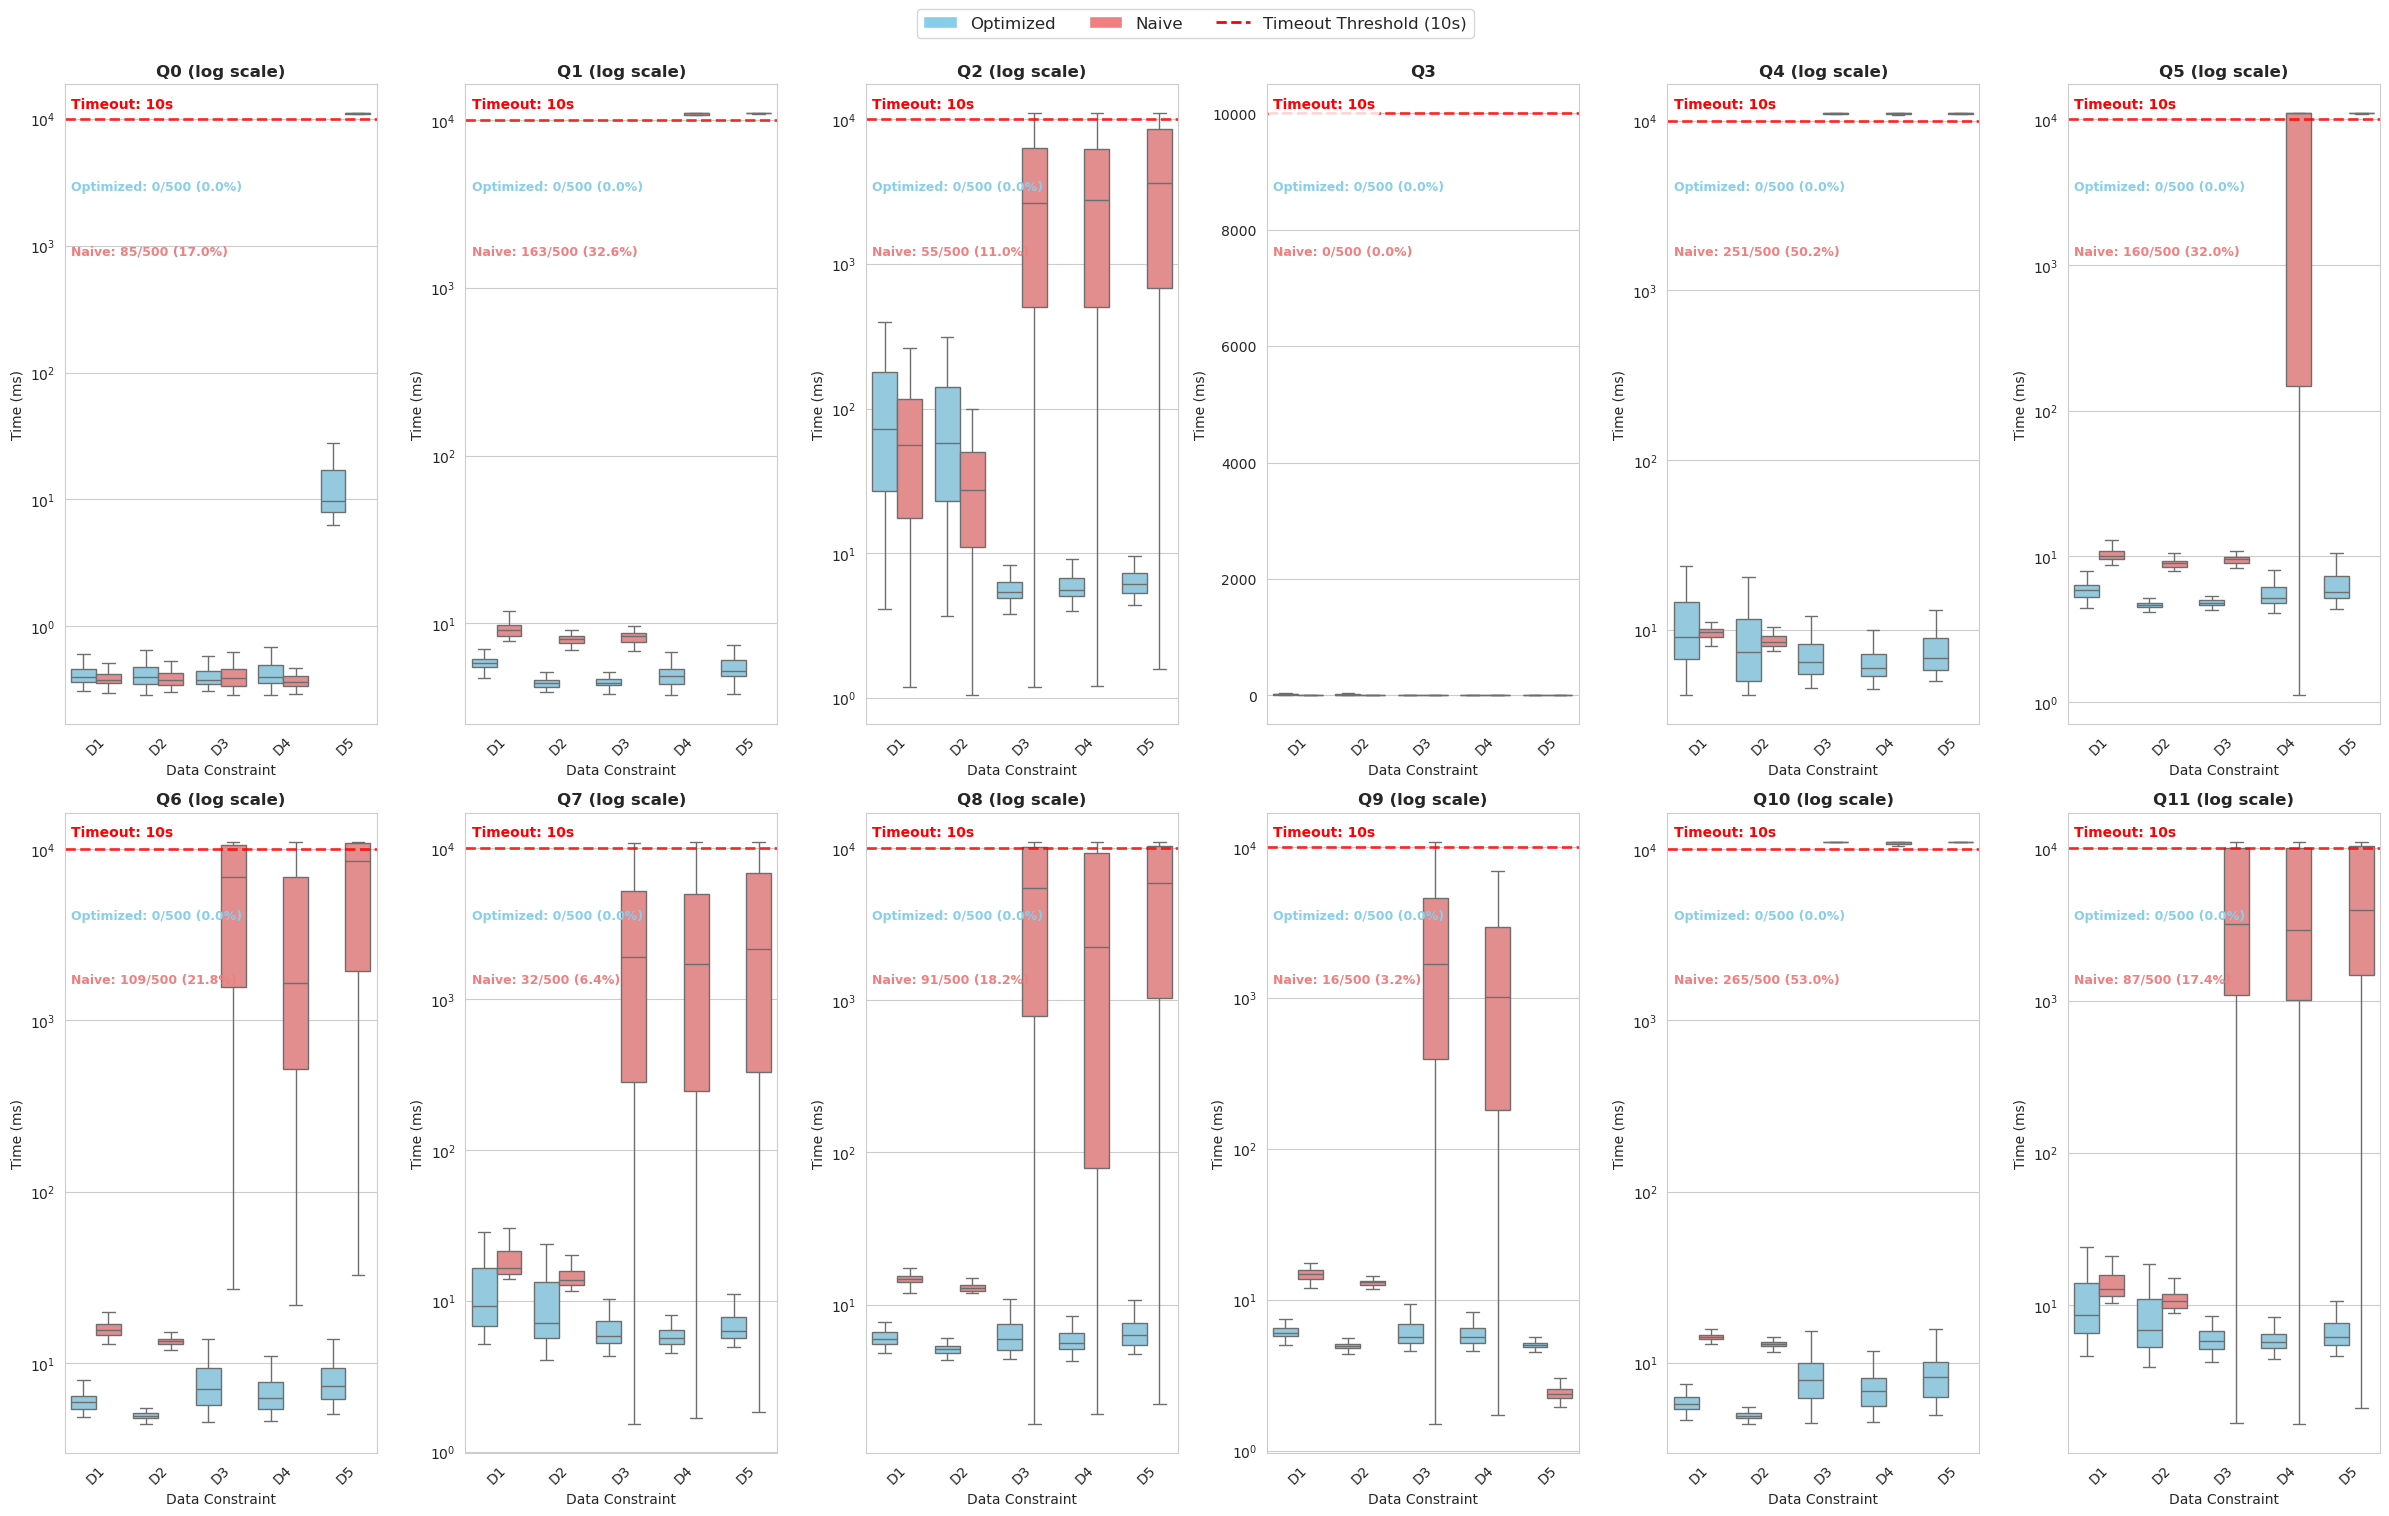

In [12]:
plot_boxplot_with_timeout("ldbc10/ldbc10_statistic.pkl", "ldbc10-naive/ldbc10_naive_statistic.pkl", ds="LDBC10", timeout=10)

In [ ]:
import pickle
import numpy
f =  open('paradise/icij_paradise_statistic.pkl', 'rb')
pickle_data = pickle.load(f)
for i in pickle_data:
        if i[1].startswith("RDPQ"):
                print(f"{i[1].split(" ")[1]} &{round(numpy.average(i[2]),2)}& {round(max(i[2]),2)} \\\\")

Q0 &0.5& 14.79 \\
Q1 &0.56& 1.52 \\
Q2 &0.36& 0.68 \\
Q3 &0.7& 1.44 \\
Q4 &0.38& 0.66 \\
Q5 &0.66& 15.63 \\
Q6 &0.4& 0.67 \\
Q7 &0.4& 0.75 \\
Q8 &0.36& 0.61 \\
Q9 &0.39& 0.92 \\
Q10 &0.48& 1.01 \\
Q11 &0.4& 0.8 \\
